In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
df = pd.read_csv("../data/raw/Rice_Cammeo_Osmancik.csv")

df['Class_encoded'] = df['Class'].map({'Cammeo': 0, 'Osmancik': 1})
X = df.drop(columns=['Class', 'Class_encoded'])  # features
y = df['Class_encoded']  # target

# Train/test split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
pred_data = []

# MODELS 

i modelli senza PCA 


### RANDOM FOREST 


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import time

# Parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Configure the RandomizedSearchCV
rf_search = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                   param_distributions=param_dist,
                                   scoring='f1',
                                   n_jobs=-1,
                                   cv=5,
                                   verbose=3,
                                   random_state=42)
# Start time
start_time = time.time()

# Fit the RandomizedSearchCV to find the best parameters
rf_search .fit(X_train, y_train)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Print the best parameters, best score, and elapsed time
print("Best Parameters:", rf_search .best_params_)
print("Best Score:", rf_search.best_score_) # best f1 sui dati di test 
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}
Best Score: 0.9386663645772193
Elapsed Time: 6.26 seconds


In [4]:
best_param_rf=rf_search.best_params_

rf = RandomForestClassifier(**best_param_rf)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.926509186351706
Precision: 0.9278846153846154
Recall: 0.9368932038834952
F1 Score: 0.9323671497584541


In [5]:
results_df.loc[len(results_df)] = ['RF', accuracy, precision, recall, f1]
pred_data.append(['RF', y_pred_prob, y_test])

### SVC


In [6]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

svc = SVC()

# Parameter distribution for RandomizedSearchCV
param_dist = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
# Configure the RandomizedSearchCV
svc_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=param_dist,
                                   scoring='f1',
                                   n_jobs=-1,
                                   cv=5,
                                   verbose=3,
                                   )
# Start time
start_time = time.time()

# Fit the RandomizedSearchCV to find the best parameters
svc_search.fit(X_scaled, y_train)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Print the best parameters, best score, and elapsed time
print("Best Parameters:", svc_search.best_params_)
print("Best Score:", svc_search.best_score_) # best f1 sui dati di test 
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'kernel': 'linear', 'gamma': 'auto', 'C': 10}
Best Score: 0.9398501526111183
Elapsed Time: 0.82 seconds


In [7]:
best_param_svc=svc_search.best_params_

svc = SVC(**best_param_svc, probability=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM model
svc.fit(X_train_scaled, y_train)

# Predict on the testing set
y_pred = svc.predict(X_test_scaled)
y_pred_prob = svc.predict_proba(X_test_scaled)[:, 1] 

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.931758530183727
Precision: 0.9347826086956522
Recall: 0.9393203883495146
F1 Score: 0.937046004842615


In [8]:
results_df.loc[len(results_df)] = ['SVC', accuracy, precision, recall, f1]
pred_data.append(['SVC', y_pred_prob, y_test])

### XGBoost


In [9]:
import xgboost as xgb

param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.3, 0.7, 1],
    'subsample': [0.7, 1]
}

# Configure the RandomizedSearchCV
xgb_search = RandomizedSearchCV(estimator=xgb.XGBClassifier(),
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   scoring='f1',
                                   n_jobs=-1,
                                   cv=5,
                                   verbose=3,
                                   random_state=42,
                                   )
# Start time
start_time = time.time()

# Fit the RandomizedSearchCV to find the best parameters
xgb_search.fit(X_train, y_train)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Print the best parameters, best score, and elapsed time
print("Best Parameters:", xgb_search.best_params_)
print("Best Score:", xgb_search.best_score_)
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.3}
Best Score: 0.9392920376585691
Elapsed Time: 8.75 seconds


In [10]:
best_param_xgb = xgb_search.best_params_

XGB = xgb.XGBClassifier(**best_param_xgb, eval_metric='logloss')

# Train the XGBoost model
XGB.fit(X_train, y_train)

# Predict on the testing set
y_pred = XGB.predict(X_test)
y_pred_prob = XGB.predict_proba(X_test)[:, 1] 

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9291338582677166
Precision: 0.9261904761904762
Recall: 0.9441747572815534
F1 Score: 0.9350961538461539


In [11]:
results_df.loc[len(results_df)] = ['XGB', accuracy, precision, recall, f1]
pred_data.append(['XGB', y_pred_prob, y_test])

## MODELLI CON PCA

### PCA

prima faccio la pca e prendo le componenti importanti


In [12]:
# Standardizzazione 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA sul dataset
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)

#Seleziona il numero di componenti che spiegano il 95% varianza 
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(explained_variance >= 0.95) + 1
print(f"Componenti selezionate: {n_components_95}")

# tengo solo le componenti importanti
pca_final = PCA(n_components=n_components_95)
X_pca = pca_final.fit_transform(X_scaled)

# Train/test split 
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)


Componenti selezionate: 3


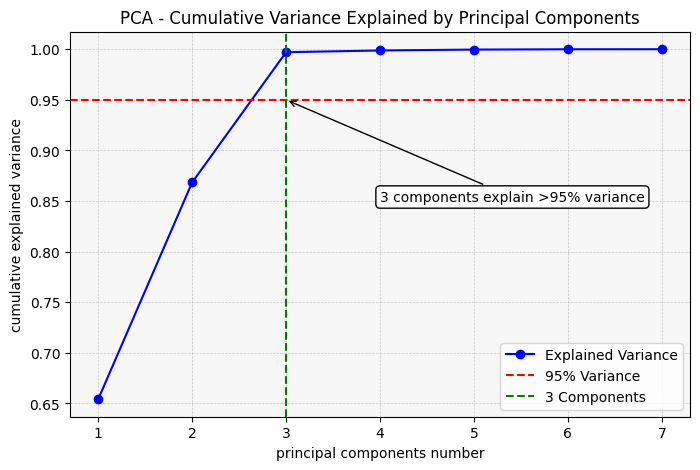

In [13]:
plt.figure(figsize=(8, 5))

plt.plot(explained_variance, marker='o', color='b', label='Explained Variance')

plt.axhline(0.95, color='r', linestyle='--', label='95% Variance')
plt.axvline(n_components_95 - 1, color='g', linestyle='--', label=f'{n_components_95} Components')
plt.xlabel('principal components number')
plt.xticks(ticks=np.arange(len(explained_variance)), labels=np.arange(1, len(explained_variance)+1))    #adjust pc ticks
plt.ylabel('cumulative explained variance')
plt.title('PCA - Cumulative Variance Explained by Principal Components')
plt.legend()

plt.annotate(f'{n_components_95} components explain >95% variance',
             xy=(n_components_95 - 1, 0.95),
             xytext=(n_components_95, 0.85),
             arrowprops=dict(color='black', arrowstyle='->'),
             fontsize=10,
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_facecolor('#f7f7f7')

plt.show()

### Naive Bayes con PCA 

In [14]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()  # Laplace smoothing
nb.fit(X_train_pca, y_train_pca)

# Predict on the testing set
y_pred = nb.predict(X_test_pca)
y_pred_prob = nb.predict_proba(X_test_pca)[:, 1] 

# Evaluation metrics
accuracy = accuracy_score(y_test_pca, y_pred)
precision = precision_score(y_test_pca, y_pred)
recall = recall_score(y_test_pca, y_pred)
f1 = f1_score(y_test_pca, y_pred)
conf_matrix = confusion_matrix(y_test_pca, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.926509186351706
Precision: 0.9178403755868545
Recall: 0.9490291262135923
F1 Score: 0.9331742243436754


In [15]:
results_df.loc[len(results_df)] = ['NB', accuracy, precision, recall, f1]
pred_data.append(['NB', y_pred_prob, y_test_pca])

### KNN con PCA

In [16]:
from sklearn.neighbors import KNeighborsClassifier

# Inizializza il classificatore
knn = KNeighborsClassifier(n_neighbors=5)

# Allena il modello
knn.fit(X_train_pca, y_train_pca)

# Predizioni
y_pred_knn = knn.predict(X_test_pca)
y_pred_prob = knn.predict_proba(X_test_pca)[:, 1] 

# Evaluation metrics
accuracy = accuracy_score(y_test_pca, y_pred_knn)
precision = precision_score(y_test_pca, y_pred_knn)
recall = recall_score(y_test_pca, y_pred_knn)
f1 = f1_score(y_test_pca, y_pred_knn)
conf_matrix = confusion_matrix(y_test_pca, y_pred_knn)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.910761154855643
Precision: 0.9114832535885168
Recall: 0.9247572815533981
F1 Score: 0.9180722891566265


In [17]:
results_df.loc[len(results_df)] = ['KNN', accuracy, precision, recall, f1]
pred_data.append(['KNN', y_pred_prob, y_test_pca])

In [18]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,RF,0.926509,0.927885,0.936893,0.932367
1,SVC,0.931759,0.934783,0.939320,0.937046
2,XGB,0.929134,0.926190,0.944175,0.935096
3,NB,0.926509,0.917840,0.949029,0.933174
4,KNN,0.910761,0.911483,0.924757,0.918072


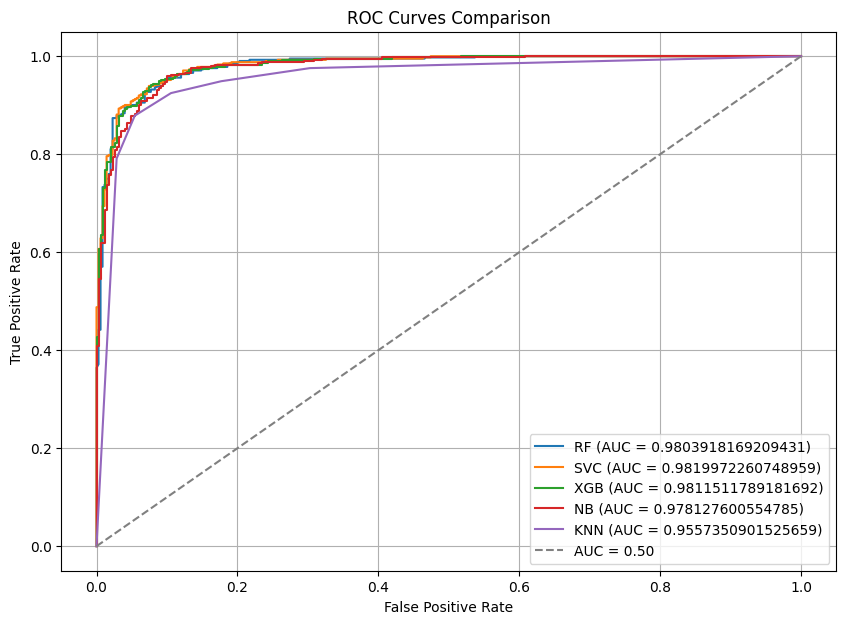

In [19]:
plt.figure(figsize=(10, 7))

for model in pred_data:
    y_true = model[2]
    y_pred_prob = model[1]

    fpr, tpr, _= roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{model[0]} (AUC = {auc})')

# Linea di riferimento per un modello casuale
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='AUC = 0.50')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()